In [52]:
import pefile
import json
import os
def save_pe_info(pe, output_file):
    # 创建一个字典来保存 PE 文件的信息
    pe_info = {}

    # 添加 DOS 头信息
    pe_info['dos_header'] = pe.DOS_HEADER.dump_dict()

    # 添加文件头信息
    pe_info['file_header'] = pe.FILE_HEADER.dump_dict()

    # 添加可选头信息
    pe_info['optional_header'] = pe.OPTIONAL_HEADER.dump_dict()

    # 添加节表信息
    pe_info['section_headers'] = [section.dump_dict() for section in pe.sections]

    # 添加导入表信息
    pe_info['imported_functions'] = {}
    for entry in pe.DIRECTORY_ENTRY_IMPORT:
        pe_info['imported_functions'][entry.dll.decode()] = [func.name.decode() for func in entry.imports]

    # 添加导出表信息
    if hasattr(pe, 'DIRECTORY_ENTRY_EXPORT'):
        pe_info['exported_functions'] = [export.name.decode() for export in pe.DIRECTORY_ENTRY_EXPORT.symbols]

    # 保存信息到文件
    with open(output_file, 'w') as f:
        json.dump(pe_info, f, indent=4)

In [53]:
for file in os.listdir('exe'):
    pe = pefile.PE(f'exe/{file}')
    # 保存 PE 文件信息到 JSON 文件
    save_pe_info(pe, f'json/{file}.json')
    pe.close()

In [54]:
# 读取 JSON 文件中的信息
import pandas as pd
data_list = []
for file in os.listdir('json'):
    with open(f'json/{file}', 'r') as f:
        pe_info = json.load(f)
        pe_info['version'] = file.split('_')[1][:2]
        data_list.append(pe_info)

In [55]:
for data in data_list:
    data.pop('dos_header')

In [56]:
featrues = []
for data in data_list:
    featrue = {}
    featrue['NumberOfSections-Value'] = data['file_header']['NumberOfSections']['Value']
    featrue['PointerToSymbolTable-Value'] = data['file_header']['PointerToSymbolTable']['Value']
    featrue['NumberOfSymbols-Value'] = data['file_header']['NumberOfSymbols']['Value']
    featrue['SizeOfOptionalHeader-Value'] = data['file_header']['SizeOfOptionalHeader']['Value']
    featrue['Characteristics-Value'] = data['file_header']['Characteristics']['Value']
    featrue['MinorLinkerVersion-Value'] = data['optional_header']['MinorLinkerVersion']['Value']
    featrue['SizeOfCode-Value'] = data['optional_header']['SizeOfCode']['Value']
    featrue['SizeOfInitializedData-Value'] = data['optional_header']['SizeOfInitializedData']['Value']
    featrue['SizeOfUninitializedData-Value'] = data['optional_header']['SizeOfUninitializedData']['Value']
    featrue['AddressOfEntryPoint-Value'] = data['optional_header']['AddressOfEntryPoint']['Value']
    featrue['BaseOfData-Value'] = data['optional_header']['BaseOfData']['Value']
    featrue['CheckSum-Value'] = data['optional_header']['CheckSum']['Value']
    featrue['DllCharacteristics-Value'] = data['optional_header']['DllCharacteristics']['Value']
    featrue['version'] = data['version']
    featrues.append(featrue)

In [57]:
data = pd.DataFrame.from_dict(featrues)

In [58]:
data.to_csv('exe.csv', index=False)

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [60]:
conlum_list = data.columns.tolist() #分离特征和目标值
conlum_list.remove('version')
features1 = data[conlum_list] #特征
target = data['version'] # 什么版本

In [61]:
model = SVC(kernel='linear')
model.fit(features1, target)

SVC(kernel='linear')

In [62]:
(model.predict(data.drop('version',axis=1)) == target).mean()

0.11764705882352941

In [63]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
confusion_matrix(target, model.predict(features1))

array([[3, 0, 0, 0, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 1]], dtype=int64)

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


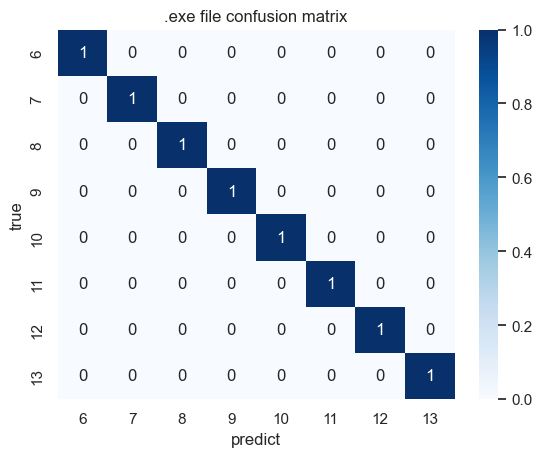

In [64]:
def plot(matrix):
  sns.set()
  f,ax=plt.subplots()
  print(matrix) #打印出来看看
  sns.heatmap(matrix,annot=True,cmap="Blues",ax=ax) #画热力图
  ax.set_title('.exe file confusion matrix') #标题
  ax.set_xticklabels(['6','7','8','9','10','11','12','13'])
  ax.set_yticklabels(['6','7','8','9','10','11','12','13'])
  ax.set_xlabel('predict') #x轴
  ax.set_ylabel('true') #y轴

matrix=confusion_matrix(target, model.predict(features1))
matrix=matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]  
con_mat_norm = np.around(matrix, decimals=2)
plot(con_mat_norm)# 画比例数据

In [65]:
from sklearn.metrics import accuracy_score, classification_report
print('Classification Report:\n', classification_report(target, model.predict(features)))

NameError: name 'features' is not defined